# BlackJack Environment 

In [2]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

class BlackjackEnvironment:
    def __init__(self, num_decks=4):
        self.num_decks = num_decks
        self.deck = []
        self.player_cards = []
        self.dealer_cards = []
        self.split_cards = []
        self.has_doubled_down = False
        self.current_hand_index = 0
        self.player_hands = []

        self.hi_lo_points = {
            '2': 1, '3': 1, '4': 1, '5': 1, '6': 1,
            '7': 0, '8': 0, '9': 0,
            '10': -1, 'jack': -1, 'queen': -1, 'king': -1, 'ace': -1
        }
        self.running_count = 0
        self.cards_seen_this_shoe = 0

        self.reset_game()

    def create_new_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = [f"{value}_{suit}" for value in values for suit in suits] * self.num_decks
        random.shuffle(deck)
        self.running_count = 0
        self.cards_seen_this_shoe = 0
        return deck

    def draw_random_card(self):
        if len(self.deck) < (self.num_decks * 52 * 0.25):
            self.deck = self.create_new_deck()
        
        card = self.deck.pop()
        self._update_running_count(card)
        return card

    def _update_running_count(self, card):
        value = card.split('_')[0]
        self.running_count += self.hi_lo_points.get(value, 0)
        self.cards_seen_this_shoe += 1

    def get_true_count(self):
        if self.num_decks * 52 - self.cards_seen_this_shoe <= 0:
            remaining_decks_approx = 0.5
        else:
            remaining_decks_approx = (self.num_decks * 52 - self.cards_seen_this_shoe) / 52.0
        
        if remaining_decks_approx < 0.5:
            remaining_decks_approx = 0.5
        
        return self.running_count / remaining_decks_approx

    def reset_game(self):
        self.player_hands = [[self.draw_random_card(), self.draw_random_card()]]
        self.dealer_cards = [self.draw_random_card(), self.draw_random_card()]
        self.current_hand_index = 0
        self.has_doubled_down = False

    def get_card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def calculate_hand_value(self, hand):
        value = sum(self.get_card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card.startswith('ace'))
        
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
            
        return value

    def has_soft_hand(self, hand):
        card_values = [self.get_card_value(card) for card in hand]
        if 11 not in card_values:
            return False
        
        temp_sum = sum(card_values)
        if temp_sum <= 21:
            return True
        
        num_aces = card_values.count(11)
        current_sum = temp_sum
        while num_aces > 0 and current_sum > 21:
            current_sum -= 10
            num_aces -= 1
        
        return 11 in [self.get_card_value(card) for card in hand] and self.calculate_hand_value(hand) <= 21

    def check_if_busted(self, hand):
        return self.calculate_hand_value(hand) > 21

    def play_dealer_hand(self):
        while self.calculate_hand_value(self.dealer_cards) < 17:
            self.dealer_cards.append(self.draw_random_card())

    def check_if_pair(self, hand):
        if len(hand) == 2:
            val1 = self.get_card_value(hand[0])
            val2 = self.get_card_value(hand[1])
            return val1 == val2
        return False
    
    def get_current_hand(self):
        return self.player_hands[self.current_hand_index]

    def execute_action(self, action):
        current_hand = self.get_current_hand()
        reward = 0
        terminal = False
        
        if action == 'h':
            current_hand.append(self.draw_random_card())
            if self.check_if_busted(current_hand):
                if self.current_hand_index < len(self.player_hands) - 1:
                    self.current_hand_index += 1
                    return self.get_current_state(), -1, False 
                else:
                    total_reward_for_round = self._evaluate_all_hands_at_end()
                    return 'terminal', total_reward_for_round, True
            
        elif action == 's':
            if self.current_hand_index < len(self.player_hands) - 1:
                self.current_hand_index += 1
                return self.get_current_state(), 0, False
            else:
                self.play_dealer_hand()
                total_reward_for_round = self._evaluate_all_hands_at_end()
                return 'terminal', total_reward_for_round, True
                
        elif action == 'p' and self.check_if_pair(current_hand) and len(current_hand) == 2 and len(self.player_hands) < 4:
            card1 = current_hand.pop(0)
            card2 = current_hand.pop(0)
            
            self.player_hands[self.current_hand_index] = [card1, self.draw_random_card()]
            self.player_hands.insert(self.current_hand_index + 1, [card2, self.draw_random_card()])
            
        elif action == 'd' and len(current_hand) == 2 and not self.has_doubled_down:
            self.has_doubled_down = True
            current_hand.append(self.draw_random_card())
            
            if self.check_if_busted(current_hand):
                if self.current_hand_index < len(self.player_hands) - 1:
                    self.current_hand_index += 1
                    return self.get_current_state(), -2, False 
                else:
                    total_reward_for_round = self._evaluate_all_hands_at_end()
                    return 'terminal', total_reward_for_round, True
            else:
                if self.current_hand_index < len(self.player_hands) - 1:
                    self.current_hand_index += 1
                    return self.get_current_state(), 0, False
                else:
                    self.play_dealer_hand()
                    total_reward_for_round = self._evaluate_all_hands_at_end()
                    return 'terminal', total_reward_for_round, True
        else:
            if self.current_hand_index < len(self.player_hands) - 1:
                self.current_hand_index += 1
                return self.get_current_state(), 0, False
            else:
                self.play_dealer_hand()
                total_reward_for_round = self._evaluate_all_hands_at_end()
                return 'terminal', total_reward_for_round, True
                
        return self.get_current_state(), 0, False

    def _evaluate_all_hands_at_end(self):
        total_profit_for_round = 0
        dealer_value = self.calculate_hand_value(self.dealer_cards)
        
        for i, hand in enumerate(self.player_hands):
            player_value = self.calculate_hand_value(hand)
            
            bet_on_this_hand = 1
            if i == 0 and self.has_doubled_down:
                bet_on_this_hand = 2

            reward_for_this_hand = 0
            
            if self.check_if_busted(hand):
                reward_for_this_hand = -1 * bet_on_this_hand
            elif self.is_blackjack(hand) and not self.is_blackjack(self.dealer_cards):
                if len(hand) == 2:
                    reward_for_this_hand = 1.5 * bet_on_this_hand
                else:
                    reward_for_this_hand = 1 * bet_on_this_hand
            elif self.check_if_busted(self.dealer_cards):
                reward_for_this_hand = 1 * bet_on_this_hand
            elif self.is_blackjack(self.dealer_cards) and not self.is_blackjack(hand):
                 reward_for_this_hand = -1 * bet_on_this_hand
            elif player_value > dealer_value:
                reward_for_this_hand = 1 * bet_on_this_hand
            elif player_value < dealer_value:
                reward_for_this_hand = -1 * bet_on_this_hand
            else:
                reward_for_this_hand = 0
            
            total_profit_for_round += reward_for_this_hand
        return total_profit_for_round

    def is_blackjack(self, hand):
        return len(hand) == 2 and self.calculate_hand_value(hand) == 21

    def get_current_state(self):
        current_hand = self.get_current_hand()
        player_value = self.calculate_hand_value(current_hand)
        dealer_up_card_value = self.get_card_value(self.dealer_cards[0])
        is_soft = self.has_soft_hand(current_hand)
        can_split = self.check_if_pair(current_hand) and len(current_hand) == 2 and len(self.player_hands) < 4
        can_double = len(current_hand) == 2 and not self.has_doubled_down

        return (player_value, dealer_up_card_value, is_soft, can_split, can_double, self.current_hand_index)




#  Basic Strategy with Q-learning 

In [3]:
class QLearningBasicStrategyAgent:
    def __init__(self, env, num_episodes=1000000, initial_epsilon=1.0, epsilon_decay=0.99999, 
                 final_epsilon=0.01, alpha=0.15, gamma=0.95):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.num_episodes = num_episodes
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.Q = defaultdict(lambda: np.zeros(4))
        self.stats = {'wins': 0, 'losses': 0, 'draws': 0, 'total_profit': 0}
        self.performance_log = []

    def get_state_key(self, state):
        player_value, dealer_upcard, is_soft, can_split, can_double, hand_index = state
        return (player_value, dealer_upcard, is_soft, can_split, can_double, hand_index) 

    def select_action(self, state):
        state_key = self.get_state_key(state)
        
        valid_actions = []
        if state[0] <= 21 and state[5] < len(self.env.player_hands): 
            valid_actions.append(0)
            valid_actions.append(1)
            if state[4]:
                valid_actions.append(2)
            if state[3]:
                valid_actions.append(3)

        if not valid_actions:
            return 1

        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            q_values = self.Q[state_key].copy()
            for i in [0,1,2,3]:
                if i not in valid_actions:
                    q_values[i] = -np.inf

            if all(q_values[i] == -np.inf for i in valid_actions):
                return random.choice(valid_actions)
            
            return np.argmax(q_values)

    def action_to_str(self, action_idx):
        actions = {0: 'h', 1: 's', 2: 'd', 3: 'p'}
        return actions[action_idx]

    def train(self):
        for episode in range(self.num_episodes):
            self.env.reset_game()
            
            initial_player_hand_value = self.env.calculate_hand_value(self.env.player_hands[0])
            initial_dealer_hand_value = self.env.calculate_hand_value(self.env.dealer_cards)
            
            initial_blackjack_outcome = 0
            
            if self.env.is_blackjack(self.env.player_hands[0]):
                initial_blackjack_outcome = 1
            
            if self.env.is_blackjack(self.env.dealer_cards):
                if initial_blackjack_outcome == 1:
                    reward = 0
                    self.stats['draws'] += 1
                else:
                    reward = -1
                    self.stats['losses'] += 1
                self.stats['total_profit'] += reward
                done = True
            elif initial_blackjack_outcome == 1:
                reward = 1.5
                self.stats['wins'] += 1
                self.stats['total_profit'] += reward
                done = True
            else:
                done = False

            if not done:
                while self.env.current_hand_index < len(self.env.player_hands):
                    current_state_for_hand = self.env.get_current_state()
                    action_idx = self.select_action(current_state_for_hand)
                    action = self.action_to_str(action_idx)
                    
                    prev_state_key = self.get_state_key(current_state_for_hand)
                    
                    next_state, reward_from_env_step, terminal_flag = self.env.execute_action(action)
                    
                    if terminal_flag == True:
                        td_target = reward_from_env_step
                        self.stats['total_profit'] += td_target
                        if td_target > 0: self.stats['wins'] += 1
                        elif td_target < 0: self.stats['losses'] += 1
                        else: self.stats['draws'] += 1
                        
                        self.Q[prev_state_key][action_idx] += self.alpha * (td_target - self.Q[prev_state_key][action_idx])
                        done = True
                        break
                    else:
                        next_state_key = self.get_state_key(next_state)
                        max_next_q = np.max(self.Q[next_state_key]) 
                        td_target = reward_from_env_step + self.gamma * max_next_q
                        self.Q[prev_state_key][action_idx] += self.alpha * (td_target - self.Q[prev_state_key][action_idx])

                    current_state_for_hand = next_state
                    
            self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)
            
            if (episode + 1) % 10000 == 0:
                self.log_performance(episode + 1)
                if (episode + 1) % 100000 == 0:
                    print(f"Basic Strategy Episode {episode + 1}, Epsilon: {self.epsilon:.4f}")

    def log_performance(self, episode):
        total_games_played = self.stats['wins'] + self.stats['losses'] + self.stats['draws']
        if total_games_played > 0:
            expected_value = self.stats['total_profit'] / total_games_played
            self.performance_log.append((episode, expected_value))

    def print_stats(self):
        total_games = self.stats['wins'] + self.stats['losses'] + self.stats['draws']
        if total_games == 0:
            print("No games played for Basic Strategy Agent.")
            return

        win_pct = self.stats['wins'] / total_games * 100
        loss_pct = self.stats['losses'] / total_games * 100
        draw_pct = self.stats['draws'] / total_games * 100
        expected_value_per_hand = self.stats['total_profit'] / total_games

        print("\nBasic Strategy Q-Learning Results:")
        print(f"Total games: {total_games}")
        print(f"Wins: {self.stats['wins']} ({win_pct:.2f}%)")
        print(f"Losses: {self.stats['losses']} ({loss_pct:.2f}%)")
        print(f"Draws: {self.stats['draws']} ({draw_pct:.2f}%)")
        print(f"Total Profit: {self.stats['total_profit']:.2f} units")
        print(f"Expected Value per Hand: {expected_value_per_hand:.4f}")




# Complete Point count with Q-learning

In [4]:
class QLearningPointCountAgent:
    def __init__(self, env, num_episodes=500000, initial_epsilon=1.0, 
                 epsilon_decay=0.99999, final_epsilon=0.01, alpha=0.15, gamma=0.95):
        self.env = env
        self.num_episodes = num_episodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.Q = defaultdict(lambda: np.zeros(4))
        self.stats = {'wins': 0, 'losses': 0, 'draws': 0, 'total_profit': 0}
        self.performance_log = []

        self.base_bet = 1
        self.betting_strategy = {
            -10: 1, -5: 1, -2: 1,
            0: 1,
            1: 2, 2: 3, 3: 4,
            4: 5, 5: 6,
            10: 7
        }
        self.bet_multipliers_keys = sorted(self.betting_strategy.keys())

    def get_bet_amount(self):
        true_count = self.env.get_true_count()
        bet_multiplier = self.base_bet
        for tc_threshold in self.bet_multipliers_keys:
            if true_count >= tc_threshold:
                bet_multiplier = self.betting_strategy[tc_threshold]
            else:
                break
        return self.base_bet * bet_multiplier

    def get_state_key(self, state):
        player_value, dealer_upcard, is_soft, can_split, can_double, hand_index = state
        
        true_count = self.env.get_true_count()
        if true_count < -2: tc_bucket = -3
        elif true_count < -1: tc_bucket = -2
        elif true_count < 0: tc_bucket = -1
        elif true_count < 1: tc_bucket = 0
        elif true_count < 2: tc_bucket = 1
        elif true_count < 3: tc_bucket = 2
        else: tc_bucket = 3
        
        return (player_value, dealer_upcard, is_soft, can_split, can_double, hand_index, tc_bucket)

    def select_action(self, state):
        state_key = self.get_state_key(state)
        
        valid_actions = []
        if state[0] <= 21 and state[5] < len(self.env.player_hands):
            valid_actions.append(0)
            valid_actions.append(1)
            if state[4]:
                valid_actions.append(2)
            if state[3]:
                valid_actions.append(3)
        
        if not valid_actions:
            return 1

        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        
        q_values = self.Q[state_key].copy()
        for i in [0,1,2,3]:
            if i not in valid_actions:
                q_values[i] = -np.inf
        
        if all(q_values[i] == -np.inf for i in valid_actions):
            return random.choice(valid_actions)

        return np.argmax(q_values)

    def action_to_str(self, action_idx):
        return ['h', 's', 'd', 'p'][action_idx]

    def train(self):
        for episode in range(self.num_episodes):
            self.env.reset_game()
            bet_amount = self.get_bet_amount()
            
            initial_player_hand_value = self.env.calculate_hand_value(self.env.player_hands[0])
            initial_dealer_hand_value = self.env.calculate_hand_value(self.env.dealer_cards)
            
            initial_blackjack_outcome = 0
            
            if self.env.is_blackjack(self.env.player_hands[0]):
                initial_blackjack_outcome = 1
            
            if self.env.is_blackjack(self.env.dealer_cards):
                if initial_blackjack_outcome == 1:
                    reward = 0
                    self.stats['draws'] += 1
                else:
                    reward = -1 * bet_amount
                    self.stats['losses'] += 1
                self.stats['total_profit'] += reward
                done = True
            elif initial_blackjack_outcome == 1:
                reward = 1.5 * bet_amount
                self.stats['wins'] += 1
                self.stats['total_profit'] += reward
                done = True
            else:
                done = False

            if not done:
                while self.env.current_hand_index < len(self.env.player_hands):
                    current_state_for_hand = self.env.get_current_state()
                    action_idx = self.select_action(current_state_for_hand)
                    action = self.action_to_str(action_idx)
                    
                    prev_state_key = self.get_state_key(current_state_for_hand)
                    
                    next_state, reward_from_env_step, terminal_flag = self.env.execute_action(action)
                    
                    if terminal_flag == True:
                        adjusted_reward = reward_from_env_step * bet_amount
                        self.stats['total_profit'] += adjusted_reward

                        if adjusted_reward > 0: self.stats['wins'] += 1
                        elif adjusted_reward < 0: self.stats['losses'] += 1
                        else: self.stats['draws'] += 1
                        
                        td_target = adjusted_reward
                        self.Q[prev_state_key][action_idx] += self.alpha * (td_target - self.Q[prev_state_key][action_idx])
                        done = True
                        break 
                    else:
                        next_state_key = self.get_state_key(next_state)
                        max_next_q = np.max(self.Q[next_state_key]) 
                        
                        td_target = (reward_from_env_step * bet_amount) + self.gamma * max_next_q
                        self.Q[prev_state_key][action_idx] += self.alpha * (td_target - self.Q[prev_state_key][action_idx])
                        
                    current_state_for_hand = next_state
            
            self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)
            
            if (episode + 1) % 10000 == 0:
                self.log_performance(episode + 1)
                if (episode + 1) % 100000 == 0:
                    print(f"Point Count Episode {episode + 1}, Epsilon: {self.epsilon:.4f}")

    def log_performance(self, episode):
        total_games_played = self.stats['wins'] + self.stats['losses'] + self.stats['draws']
        if total_games_played > 0:
            expected_value = self.stats['total_profit'] / total_games_played
            self.performance_log.append((episode, expected_value))

    def print_stats(self):
        total_games = self.stats['wins'] + self.stats['losses'] + self.stats['draws']
        if total_games == 0:
            print("No games played for Point Count Agent.")
            return

        win_pct = self.stats['wins'] / total_games * 100
        loss_pct = self.stats['losses'] / total_games * 100
        draw_pct = self.stats['draws'] / total_games * 100
        expected_value_per_hand = self.stats['total_profit'] / total_games

        print("\nPoint Count Q-Learning Results:")
        print(f"Total games: {total_games}")
        print(f"Wins: {self.stats['wins']} ({win_pct:.2f}%)")
        print(f"Losses: {self.stats['losses']} ({loss_pct:.2f}%)")
        print(f"Draws: {self.stats['draws']} ({draw_pct:.2f}%)")
        print(f"Total Profit: {self.stats['total_profit']:.2f} units")
        print(f"Expected Value per Hand: {expected_value_per_hand:.4f}")


if __name__ == "__main__":
    env_basic = BlackjackEnvironment(num_decks=4)
    env_point_count = BlackjackEnvironment(num_decks=4)

    print("Training Q-Learning Basic Strategy Agent...")
    basic_agent = QLearningBasicStrategyAgent(env_basic, num_episodes=1500000)
    basic_agent.train()
    basic_agent.print_stats()

    print("\nTraining Q-Learning Point Count Agent...")
    point_count_agent = QLearningPointCountAgent(env_point_count, num_episodes=1500000)
    point_count_agent.train()
    point_count_agent.print_stats()


Training Q-Learning Basic Strategy Agent...
Basic Strategy Episode 100000, Epsilon: 0.3679
Basic Strategy Episode 200000, Epsilon: 0.1353
Basic Strategy Episode 300000, Epsilon: 0.0498
Basic Strategy Episode 400000, Epsilon: 0.0183
Basic Strategy Episode 500000, Epsilon: 0.0100
Basic Strategy Episode 600000, Epsilon: 0.0100
Basic Strategy Episode 700000, Epsilon: 0.0100
Basic Strategy Episode 800000, Epsilon: 0.0100
Basic Strategy Episode 900000, Epsilon: 0.0100
Basic Strategy Episode 1000000, Epsilon: 0.0100
Basic Strategy Episode 1100000, Epsilon: 0.0100
Basic Strategy Episode 1200000, Epsilon: 0.0100
Basic Strategy Episode 1300000, Epsilon: 0.0100
Basic Strategy Episode 1400000, Epsilon: 0.0100
Basic Strategy Episode 1500000, Epsilon: 0.0100

Basic Strategy Q-Learning Results:
Total games: 1500000
Wins: 601543 (40.10%)
Losses: 755674 (50.38%)
Draws: 142783 (9.52%)
Total Profit: -137341.00 units
Expected Value per Hand: -0.0916

Training Q-Learning Point Count Agent...
Point Count Ep


Generating enhanced performance comparison graph...


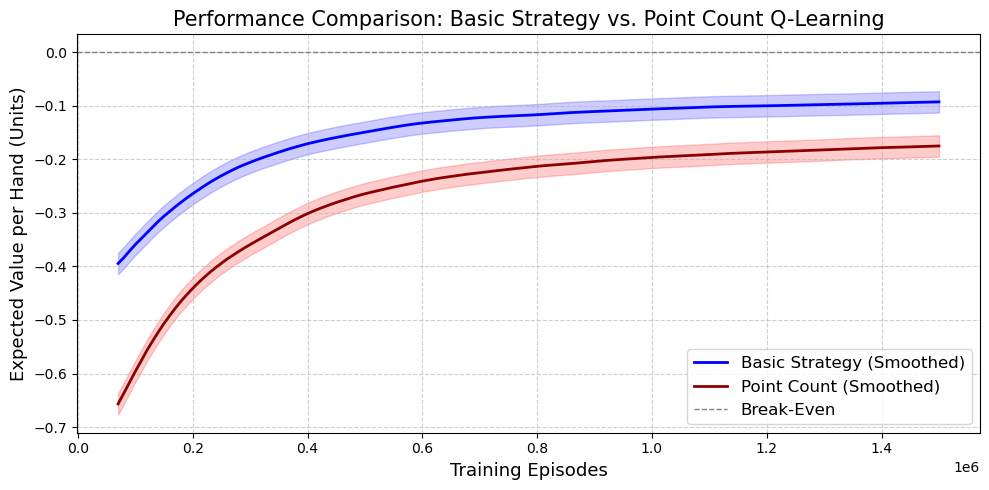

In [5]:

def moving_average(values, window=7):
    if len(values) < window:
        return values
    return np.convolve(values, np.ones(window)/window, mode='valid')

def plot_comparison(basic_strategy_log, point_count_log, window=10):
    plt.figure(figsize=(10, 5))

    # Unpack logs
    episodes_bs = np.array([log[0] for log in basic_strategy_log])
    ev_values_bs = np.array([log[1] for log in basic_strategy_log])
    episodes_pc = np.array([log[0] for log in point_count_log])
    ev_values_pc = np.array([log[1] for log in point_count_log])

    # Smoothing
    smoothed_ev_bs = moving_average(ev_values_bs, window)
    smoothed_ev_pc = moving_average(ev_values_pc, window)

    # Adjust episode alignment after smoothing
    episodes_bs = episodes_bs[len(episodes_bs) - len(smoothed_ev_bs):]
    episodes_pc = episodes_pc[len(episodes_pc) - len(smoothed_ev_pc):]

    # Plot
    plt.plot(episodes_bs, smoothed_ev_bs, label='Basic Strategy (Smoothed)', color='blue', linewidth=2.0)
    plt.plot(episodes_pc, smoothed_ev_pc, label='Point Count (Smoothed)', color='darkred', linewidth=2.0)

    # Shaded confidence-like area
    plt.fill_between(episodes_bs, smoothed_ev_bs - 0.02, smoothed_ev_bs + 0.02, color='blue', alpha=0.2)
    plt.fill_between(episodes_pc, smoothed_ev_pc - 0.02, smoothed_ev_pc + 0.02, color='red', alpha=0.2)

    # Styling
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Break-Even')
    plt.xlabel("Training Episodes", fontsize=13)
    plt.ylabel("Expected Value per Hand (Units)", fontsize=13)
    plt.title("Performance Comparison: Basic Strategy vs. Point Count Q-Learning", fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

print("\nGenerating enhanced performance comparison graph...")
plot_comparison(basic_agent.performance_log, point_count_agent.performance_log, window=7)


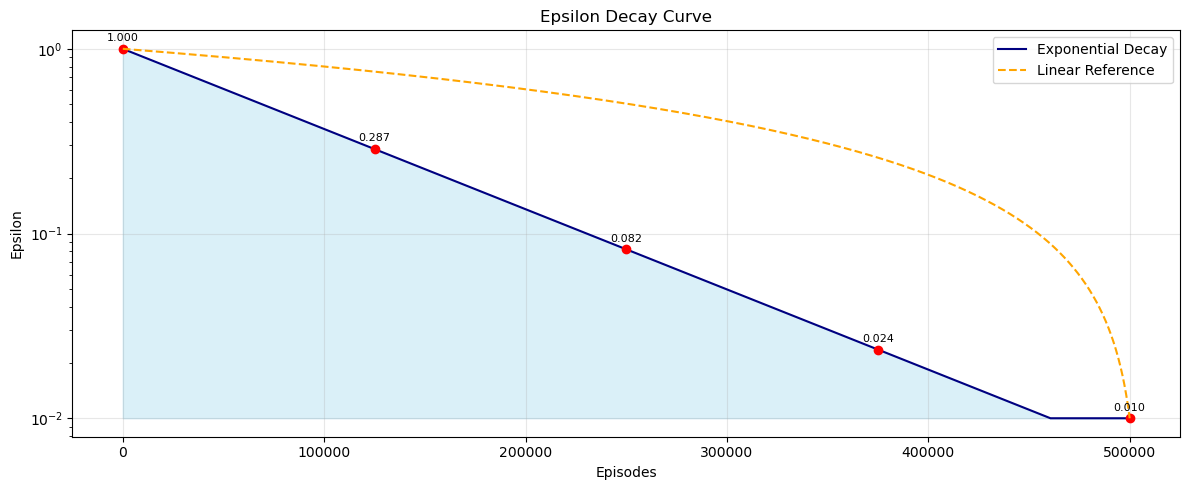

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_epsilon_decay(num_episodes, epsilon_decay, final_epsilon=0.01, show_linear=True):
    eps = 1.0
    eps_vals = [eps := max(final_epsilon, eps * epsilon_decay) for _ in range(num_episodes)]
    x = np.arange(num_episodes)

    plt.figure(figsize=(12, 5))
    plt.plot(x, eps_vals, label='Exponential Decay', color='navy')
    plt.fill_between(x, eps_vals, final_epsilon, color='skyblue', alpha=0.3)

    milestones = [0, num_episodes//4, num_episodes//2, 3*num_episodes//4, num_episodes-1]
    for i in milestones:
        plt.plot(x[i], eps_vals[i], 'ro')
        plt.text(x[i], eps_vals[i]*1.1, f"{eps_vals[i]:.3f}", ha='center', fontsize=8)

    if show_linear:
        plt.plot(x, np.linspace(1.0, final_epsilon, num_episodes), '--', color='orange', label='Linear Reference')

    plt.xlabel("Episodes"), plt.ylabel("Epsilon"), plt.yscale("log")
    plt.title("Epsilon Decay Curve"), plt.grid(True, alpha=0.3), plt.legend()
    plt.tight_layout(), plt.show()

# Example usage
plot_epsilon_decay(num_episodes=500000, epsilon_decay=0.99999)



Visualizing Basic Strategy Agent...


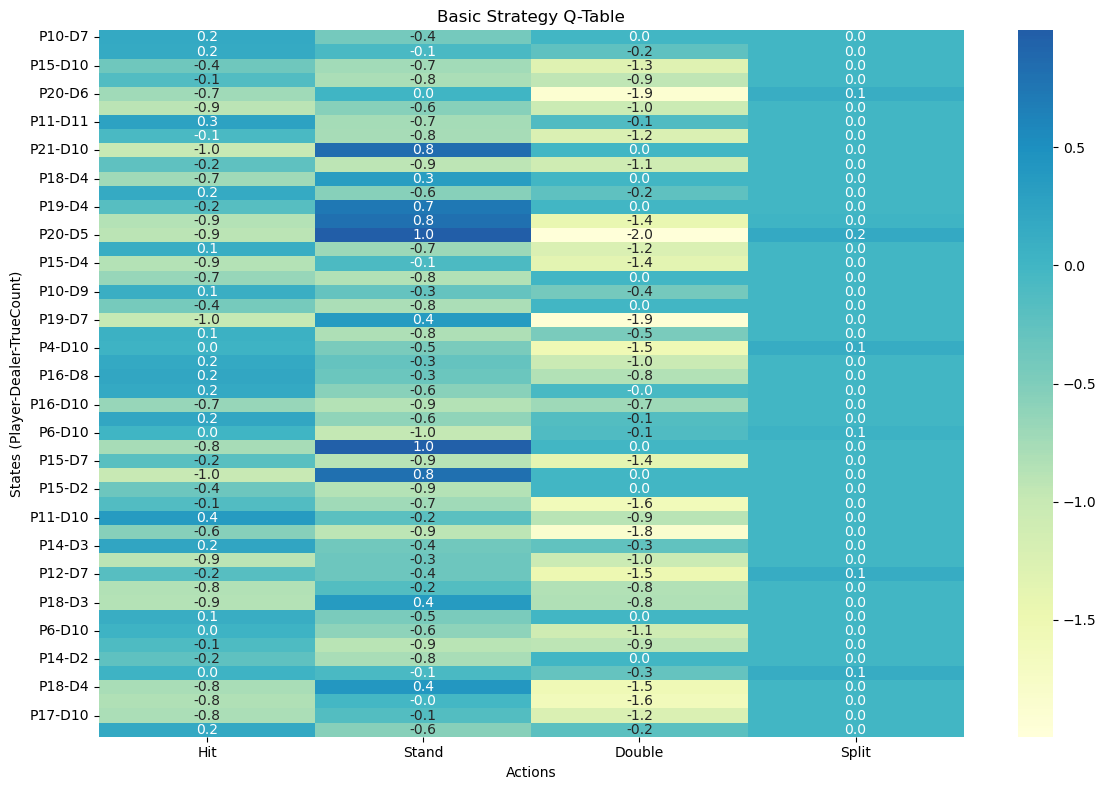

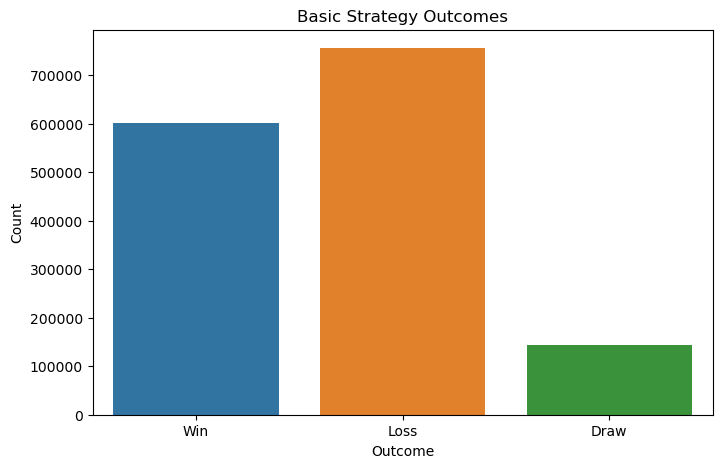


Visualizing Point Count Agent...


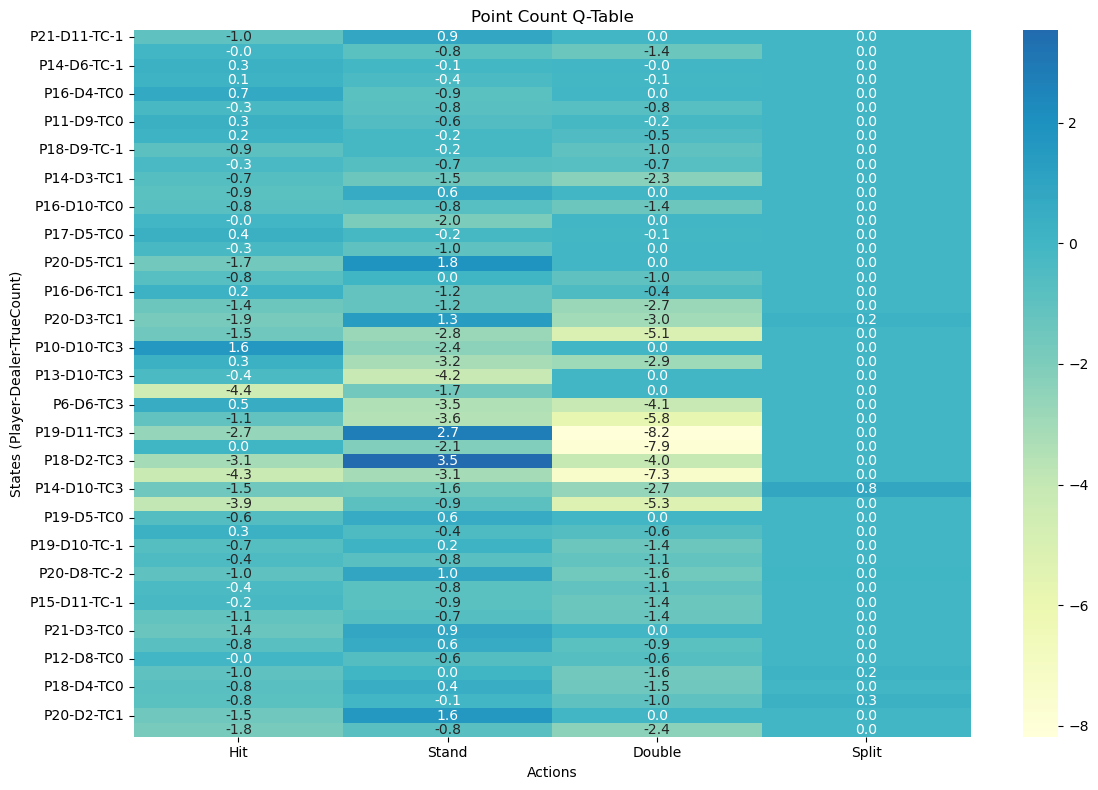

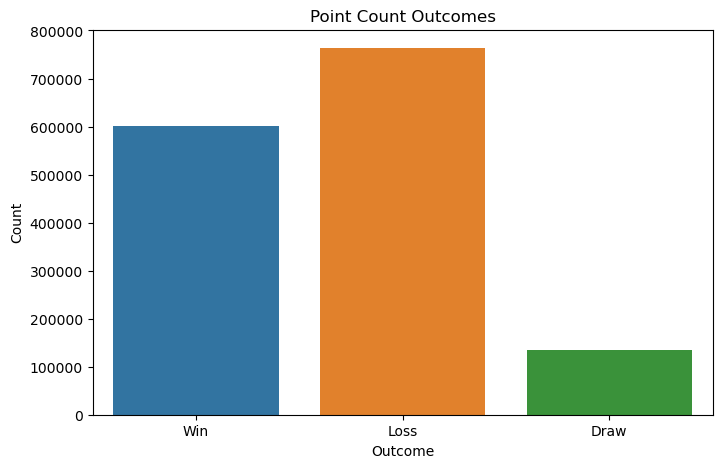


True Count Distribution...


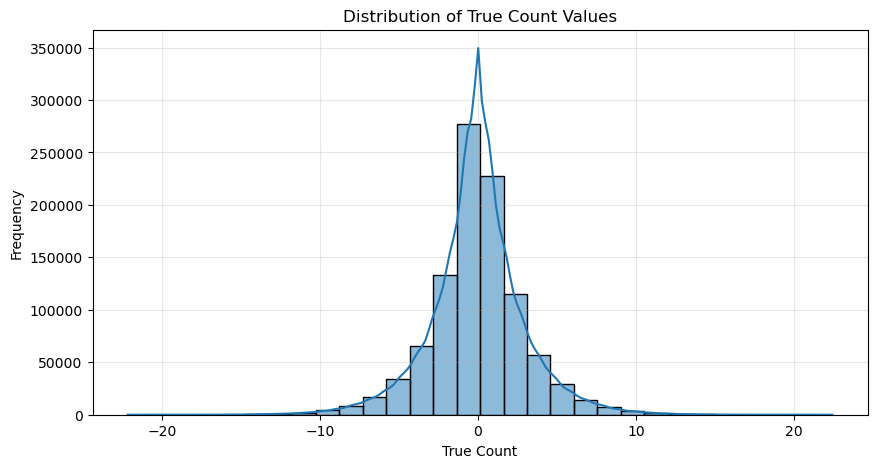

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_q_table(agent, title="Q-Table Heatmap"):
    # Extract all states from Q-table
    states = list(agent.Q.keys())
    
    if not states:
        print("Q-table is empty")
        return
    
    # Create a simplified state representation for visualization
    simplified_states = []
    q_values = []
    
    for state in states:
        player_val, dealer_val, is_soft, can_split, can_double, hand_idx, *rest = state
        # For point count agent which has true count bucket
        if len(rest) > 0:  
            tc_bucket = rest[0]
            simplified_states.append(f"P{player_val}-D{dealer_val}-TC{tc_bucket}")
        else:
            simplified_states.append(f"P{player_val}-D{dealer_val}")
        q_values.append(agent.Q[state])
    
    # Create a DataFrame for visualization
    actions = ['Hit', 'Stand', 'Double', 'Split']
    df = pd.DataFrame(q_values, index=simplified_states, columns=actions)
    
    # Plot heatmap - show only first 50 states if too many
    plt.figure(figsize=(12, min(8, len(df)/2)))
    sns.heatmap(df.head(50), cmap="YlGnBu", annot=True, fmt=".1f", center=0)
    plt.title(title)
    plt.xlabel("Actions")
    plt.ylabel("States (Player-Dealer-TrueCount)")
    plt.tight_layout()
    plt.show()

def visualize_policy(agent, title="Learned Policy"):
    # Create all possible states
    player_values = range(4, 22)
    dealer_values = range(2, 12)
    soft_states = [False, True]
    
    # Create policy matrix
    policy_matrix = np.zeros((len(player_values), len(dealer_values), len(soft_states)))
    
    for i, pv in enumerate(player_values):
        for j, dv in enumerate(dealer_values):
            for k, is_soft in enumerate(soft_states):
                state = (pv, dv, is_soft, False, False, 0)
                if len(agent.get_state_key(state)) > 6:  # For point count agent
                    state = (pv, dv, is_soft, False, False, 0, 0)  # Using TC=0 bucket
                state_key = agent.get_state_key(state)
                if state_key in agent.Q:
                    action = np.argmax(agent.Q[state_key])
                    policy_matrix[i, j, k] = action
    
    # Plot hard and soft policies
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    action_names = ['H', 'S', 'D', 'P']
    
    for k, is_soft in enumerate(soft_states):
        ax = axes[k]
        sns.heatmap(policy_matrix[:, :, k], ax=ax, cmap="YlGnBu", 
                   annot=True, fmt=".0f", cbar=False,
                   xticklabels=dealer_values, yticklabels=player_values)
        ax.set_title(f"{'Soft' if is_soft else 'Hard'} Hand Policy")
        ax.set_xlabel("Dealer Up Card")
        ax.set_ylabel("Player Total")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_betting_strategy(agent):
    if not hasattr(agent, 'betting_strategy'):
        print("This agent doesn't have a betting strategy")
        return
    
    true_counts = np.arange(-5, 6, 0.5)
    bet_amounts = [agent.betting_strategy.get(min(agent.betting_strategy.keys(), 
                     key=lambda x: abs(x - tc)), 1) for tc in true_counts]
    
    plt.figure(figsize=(10, 5))
    plt.plot(true_counts, bet_amounts, 'o-', linewidth=2)
    plt.xlabel("True Count")
    plt.ylabel("Bet Amount (Units)")
    plt.title("Betting Strategy Based on True Count")
    plt.grid(True)
    plt.show()

def enhanced_performance_comparison(basic_log, point_log):
    if not basic_log or not point_log:
        print("No performance data available")
        return
    
    # Convert to numpy arrays
    basic_episodes, basic_ev = zip(*basic_log)
    point_episodes, point_ev = zip(*point_log)
    
    # Create smoothed versions
    window_size = min(10, len(basic_ev)//10)
    if window_size < 1:
        window_size = 1
    
    basic_smooth = np.convolve(basic_ev, np.ones(window_size)/window_size, mode='valid')
    point_smooth = np.convolve(point_ev, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(14, 7))
    
    # Smoothed data
    plt.plot(basic_episodes[len(basic_episodes)-len(basic_smooth):], 
             basic_smooth, 'b-', linewidth=2, label='Basic (smoothed)')
    plt.plot(point_episodes[len(point_episodes)-len(point_smooth):], 
             point_smooth, 'r-', linewidth=2, label='Point Count (smoothed)')
    
    plt.xlabel("Episodes")
    plt.ylabel("Expected Value per Hand (Units)")
    plt.title("Performance Comparison (Smoothed)")
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_win_loss_distribution(agent, title="Win/Loss Distribution"):
    outcomes = []
    if agent.stats['wins'] > 0:
        outcomes.extend(['Win'] * agent.stats['wins'])
    if agent.stats['losses'] > 0:
        outcomes.extend(['Loss'] * agent.stats['losses'])
    if agent.stats['draws'] > 0:
        outcomes.extend(['Draw'] * agent.stats['draws'])
    
    if not outcomes:
        print("No outcome data available")
        return
    
    plt.figure(figsize=(8, 5))
    sns.countplot(x=outcomes, order=['Win', 'Loss', 'Draw'])
    plt.title(title)
    plt.xlabel("Outcome")
    plt.ylabel("Count")
    plt.show()

def plot_true_count_distribution(env, num_samples=1000000):
    true_counts = []
    for _ in range(num_samples):
        env.reset_game()
        true_counts.append(env.get_true_count())
    
    plt.figure(figsize=(10, 5))
    sns.histplot(true_counts, bins=30, kde=True)
    plt.title("Distribution of True Count Values")
    plt.xlabel("True Count")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()

# After training your agents, run these visualizations:
print("\nVisualizing Basic Strategy Agent...")
visualize_q_table(basic_agent, "Basic Strategy Q-Table")
# visualize_policy(basic_agent, "Basic Strategy Policy")
plot_win_loss_distribution(basic_agent, "Basic Strategy Outcomes")

print("\nVisualizing Point Count Agent...")
visualize_q_table(point_count_agent, "Point Count Q-Table")
# visualize_policy(point_count_agent, "Point Count Policy")
# visualize_betting_strategy(point_count_agent)
plot_win_loss_distribution(point_count_agent, "Point Count Outcomes")

# print("\nPerformance Comparison...")
# enhanced_performance_comparison(basic_agent.performance_log, point_count_agent.performance_log)

print("\nTrue Count Distribution...")
plot_true_count_distribution(env_point_count)

# Rule Variation 

In [8]:
def evaluate_rule_variations():
    # Define the rule variations to test
    rule_variations = [
        None,  # Standard rules (baseline)
        'dealer_hits_soft17',
        'double_after_split'
    ]
    
    variation_names = [
        "Standard Rules",
        "Dealer Hits Soft 17",
        "Double After Split Allowed"
    ]
    
    # Results storage
    basic_strategy_results = []
    point_count_results = []
    
    # Test each rule variation
    for i, variation in enumerate(rule_variations):
        print(f"\n=== Evaluating {variation_names[i]} ===")
        
        # Basic Strategy Agent
        print("\nTraining Basic Strategy Agent...")
        env_basic = BlackjackEnvironment(num_decks=4) if variation is None else BlackjackEnvironmentWithRuleVariations(num_decks=4, rule_variation=variation)
        basic_agent = QLearningBasicStrategyAgent(env_basic, num_episodes=1500000)
        basic_agent.train()
        basic_agent.print_stats()
        basic_strategy_results.append((variation_names[i], basic_agent.stats.copy()))
        
        # Point Count Agent
        print("\nTraining Point Count Agent...")
        env_point = BlackjackEnvironment(num_decks=4) if variation is None else BlackjackEnvironmentWithRuleVariations(num_decks=4, rule_variation=variation)
        point_agent = QLearningPointCountAgent(env_point, num_episodes=1500000)
        point_agent.train()
        point_agent.print_stats()
        point_count_results.append((variation_names[i], point_agent.stats.copy()))
    
    # Print comparison tables
    print("\n\n=== Basic Strategy Comparison ===")
    print("{:<25} {:<10} {:<10} {:<10} {:<15}".format(
        "Rule Variation", "Win %", "Loss %", "Draw %", "Expected Value"))
    for name, stats in basic_strategy_results:
        total = stats['wins'] + stats['losses'] + stats['draws']
        win_pct = stats['wins'] / total * 100
        loss_pct = stats['losses'] / total * 100
        draw_pct = stats['draws'] / total * 100
        ev = stats['total_profit'] / total
        print("{:<25} {:<10.2f} {:<10.2f} {:<10.2f} {:<15.4f}".format(
            name, win_pct, loss_pct, draw_pct, ev))
    
    print("\n\n=== Point Count Strategy Comparison ===")
    print("{:<25} {:<10} {:<10} {:<10} {:<15}".format(
        "Rule Variation", "Win %", "Loss %", "Draw %", "Expected Value"))
    for name, stats in point_count_results:
        total = stats['wins'] + stats['losses'] + stats['draws']
        win_pct = stats['wins'] / total * 100
        loss_pct = stats['losses'] / total * 100
        draw_pct = stats['draws'] / total * 100
        ev = stats['total_profit'] / total
        print("{:<25} {:<10.2f} {:<10.2f} {:<10.2f} {:<15.4f}".format(
            name, win_pct, loss_pct, draw_pct, ev))
    
    


class BlackjackEnvironmentWithRuleVariations(BlackjackEnvironment):
    def __init__(self, num_decks=4, rule_variation=None):
        super().__init__(num_decks)
        self.rule_variation = rule_variation
    
    def play_dealer_hand(self):
        dealer_value = self.calculate_hand_value(self.dealer_cards)
        
        # Rule variation: dealer hits on soft 17
        if self.rule_variation == 'dealer_hits_soft17':
            while dealer_value < 17 or (dealer_value == 17 and self.has_soft_hand(self.dealer_cards)):
                self.dealer_cards.append(self.draw_random_card())
                dealer_value = self.calculate_hand_value(self.dealer_cards)
        else:
            # Standard rules: dealer stands on all 17s
            while dealer_value < 17:
                self.dealer_cards.append(self.draw_random_card())
                dealer_value = self.calculate_hand_value(self.dealer_cards)
    
    def execute_action(self, action):
        # Handle double after split rule variation
        if self.rule_variation == 'double_after_split' and action == 'd':
            # Allow double on any first move (including after split)
            return super().execute_action(action)
        elif action == 'd' and self.current_hand_index > 0:
            # Standard rules - can't double after split
            return self.get_current_state(), 0, False
        else:
            return super().execute_action(action)

if __name__ == "__main__":
    # Run the rule variation evaluation
    evaluate_rule_variations()


=== Evaluating Standard Rules ===

Training Basic Strategy Agent...
Basic Strategy Episode 100000, Epsilon: 0.3679
Basic Strategy Episode 200000, Epsilon: 0.1353
Basic Strategy Episode 300000, Epsilon: 0.0498
Basic Strategy Episode 400000, Epsilon: 0.0183
Basic Strategy Episode 500000, Epsilon: 0.0100
Basic Strategy Episode 600000, Epsilon: 0.0100
Basic Strategy Episode 700000, Epsilon: 0.0100
Basic Strategy Episode 800000, Epsilon: 0.0100
Basic Strategy Episode 900000, Epsilon: 0.0100
Basic Strategy Episode 1000000, Epsilon: 0.0100
Basic Strategy Episode 1100000, Epsilon: 0.0100
Basic Strategy Episode 1200000, Epsilon: 0.0100
Basic Strategy Episode 1300000, Epsilon: 0.0100
Basic Strategy Episode 1400000, Epsilon: 0.0100
Basic Strategy Episode 1500000, Epsilon: 0.0100

Basic Strategy Q-Learning Results:
Total games: 1500000
Wins: 602745 (40.18%)
Losses: 756091 (50.41%)
Draws: 141164 (9.41%)
Total Profit: -136173.00 units
Expected Value per Hand: -0.0908

Training Point Count Agent...


# Updated Point count with Double Q learning

In [9]:
class DoubleQLearningPointCountAgent:
    def __init__(self, env, num_episodes=500000, initial_epsilon=1.0, 
                 epsilon_decay=0.99999, final_epsilon=0.01, alpha=0.015, gamma=0.95):
        self.env = env
        self.num_episodes = num_episodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.Q1 = defaultdict(lambda: np.zeros(4))  # First Q-table
        self.Q2 = defaultdict(lambda: np.zeros(4))  # Second Q-table
        self.stats = {'wins': 0, 'losses': 0, 'draws': 0, 'total_profit': 0}
        self.performance_log = []

        # Keep the same point counting rules and betting strategy
        self.base_bet = 1
        self.betting_strategy = {
            -10: 1, -5: 1, -2: 1,
            0: 1,
            1: 2, 2: 3, 3: 4,
            4: 5, 5: 6,
            10: 7
        }
        self.bet_multipliers_keys = sorted(self.betting_strategy.keys())

    def get_bet_amount(self):
        true_count = self.env.get_true_count()
        bet_multiplier = self.base_bet
        for tc_threshold in self.bet_multipliers_keys:
            if true_count >= tc_threshold:
                bet_multiplier = self.betting_strategy[tc_threshold]
            else:
                break
        return self.base_bet * bet_multiplier

    def get_state_key(self, state):
        player_value, dealer_upcard, is_soft, can_split, can_double, hand_index = state
        
        true_count = self.env.get_true_count()
        if true_count < -2: tc_bucket = -3
        elif true_count < -1: tc_bucket = -2
        elif true_count < 0: tc_bucket = -1
        elif true_count < 1: tc_bucket = 0
        elif true_count < 2: tc_bucket = 1
        elif true_count < 3: tc_bucket = 2
        else: tc_bucket = 3
        
        return (player_value, dealer_upcard, is_soft, can_split, can_double, hand_index, tc_bucket)

    def select_action(self, state):
        state_key = self.get_state_key(state)
        
        valid_actions = []
        if state[0] <= 21 and state[5] < len(self.env.player_hands):
            valid_actions.append(0)  # hit
            valid_actions.append(1)  # stand
            if state[4]:  # can double
                valid_actions.append(2)
            if state[3]:  # can split
                valid_actions.append(3)
        
        if not valid_actions:
            return 1  # default to stand

        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        
        # Use sum of both Q-tables for action selection
        q_values = self.Q1[state_key] + self.Q2[state_key]
        for i in range(4):
            if i not in valid_actions:
                q_values[i] = -np.inf
        
        if all(q_values[i] == -np.inf for i in valid_actions):
            return random.choice(valid_actions)

        return np.argmax(q_values)

    def action_to_str(self, action_idx):
        return ['h', 's', 'd', 'p'][action_idx]

    def train(self):
        for episode in range(self.num_episodes):
            self.env.reset_game()
            bet_amount = self.get_bet_amount()
            
            # Check for immediate blackjack outcomes
            if self.env.is_blackjack(self.env.player_hands[0]):
                if self.env.is_blackjack(self.env.dealer_cards):
                    reward = 0
                    self.stats['draws'] += 1
                else:
                    reward = 1.5 * bet_amount
                    self.stats['wins'] += 1
                self.stats['total_profit'] += reward
                continue
            elif self.env.is_blackjack(self.env.dealer_cards):
                reward = -1 * bet_amount
                self.stats['losses'] += 1
                self.stats['total_profit'] += reward
                continue

            current_state = self.env.get_current_state()
            done = False
            episode_reward = 0
            
            while not done and self.env.current_hand_index < len(self.env.player_hands):
                action_idx = self.select_action(current_state)
                action = self.action_to_str(action_idx)
                
                prev_state_key = self.get_state_key(current_state)
                next_state, step_reward, terminal = self.env.execute_action(action)
                
                if terminal:
                    episode_reward = step_reward * bet_amount
                    done = True
                    next_state_key = 'terminal'
                else:
                    next_state_key = self.get_state_key(next_state)
                
                # Double Q-Learning update
                if random.random() < 0.5:
                    # Update Q1
                    best_next_action = np.argmax(self.Q1[next_state_key]) if next_state_key != 'terminal' else 0
                    td_target = (step_reward * bet_amount) + (0 if terminal else self.gamma * self.Q2[next_state_key][best_next_action])
                    td_error = td_target - self.Q1[prev_state_key][action_idx]
                    self.Q1[prev_state_key][action_idx] += self.alpha * td_error
                else:
                    # Update Q2
                    best_next_action = np.argmax(self.Q2[next_state_key]) if next_state_key != 'terminal' else 0
                    td_target = (step_reward * bet_amount) + (0 if terminal else self.gamma * self.Q1[next_state_key][best_next_action])
                    td_error = td_target - self.Q2[prev_state_key][action_idx]
                    self.Q2[prev_state_key][action_idx] += self.alpha * td_error
                
                current_state = next_state
            
            # Update stats
            if episode_reward > 0:
                self.stats['wins'] += 1
            elif episode_reward < 0:
                self.stats['losses'] += 1
            else:
                self.stats['draws'] += 1
            self.stats['total_profit'] += episode_reward
            
            # Decay epsilon
            self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)
            
            # Log performance
            if (episode + 1) % 10000 == 0:
                total_games = self.stats['wins'] + self.stats['losses'] + self.stats['draws']
                if total_games > 0:
                    expected_value = self.stats['total_profit'] / total_games
                    self.performance_log.append((episode + 1, expected_value))
                if (episode + 1) % 100000 == 0:
                    print(f"Double Q-Learning Point Count Episode {episode + 1}, Epsilon: {self.epsilon:.4f}, Current EV: {expected_value:.4f}")

    def print_stats(self):
        total_games = self.stats['wins'] + self.stats['losses'] + self.stats['draws']
        if total_games == 0:
            print("No games played for Double Q-Learning Point Count Agent.")
            return

        win_pct = self.stats['wins'] / total_games * 100
        loss_pct = self.stats['losses'] / total_games * 100
        draw_pct = self.stats['draws'] / total_games * 100
        expected_value_per_hand = self.stats['total_profit'] / total_games

        print("\nDouble Q-Learning Point Count Results:")
        print(f"Total games: {total_games}")
        print(f"Wins: {self.stats['wins']} ({win_pct:.2f}%)")
        print(f"Losses: {self.stats['losses']} ({loss_pct:.2f}%)")
        print(f"Draws: {self.stats['draws']} ({draw_pct:.2f}%)")
        print(f"Total Profit: {self.stats['total_profit']:.2f} units")
        print(f"Expected Value per Hand: {expected_value_per_hand:.6f}")


if __name__ == "__main__":
    env_point_count = BlackjackEnvironment(num_decks=4)

    print("\nTraining Double Q-Learning Point Count Agent...")
    double_q_agent = DoubleQLearningPointCountAgent(env_point_count, num_episodes=1500000)
    double_q_agent.train()
    double_q_agent.print_stats()


Training Double Q-Learning Point Count Agent...
Double Q-Learning Point Count Episode 100000, Epsilon: 0.4040, Current EV: -0.5335
Double Q-Learning Point Count Episode 200000, Epsilon: 0.1634, Current EV: -0.4097
Double Q-Learning Point Count Episode 300000, Epsilon: 0.0659, Current EV: -0.3303
Double Q-Learning Point Count Episode 400000, Epsilon: 0.0266, Current EV: -0.2732
Double Q-Learning Point Count Episode 600000, Epsilon: 0.0100, Current EV: -0.2078
Double Q-Learning Point Count Episode 700000, Epsilon: 0.0100, Current EV: -0.1870
Double Q-Learning Point Count Episode 800000, Epsilon: 0.0100, Current EV: -0.1709
Double Q-Learning Point Count Episode 1000000, Epsilon: 0.0100, Current EV: -0.1482
Double Q-Learning Point Count Episode 1100000, Epsilon: 0.0100, Current EV: -0.1406
Double Q-Learning Point Count Episode 1200000, Epsilon: 0.0100, Current EV: -0.1331
Double Q-Learning Point Count Episode 1400000, Epsilon: 0.0100, Current EV: -0.1212
Double Q-Learning Point Count Epis